# 注意力评分函数

We used a number of different distance-based kernels, including a Gaussian kernel to model interactions between queries and keys. As it turns out, distance functions are slightly more expensive to compute than dot products. As such, with the softmax operation to ensure nonnegative attention weights, much of the work has gone into attention scoring functions in (11.1.3) and Fig. 11.3.1 that are simpler to compute.

我们使用了多种基于距离的核函数，包括高斯核函数来建模查询和键之间的交互。事实证明，距离函数的计算成本比点积略高。因此，在（11.1.3）式和图 11.3.1 中，为了确保注意力权重非负，很多工作都集中在计算更简单的 *注意力评分函数* 上。

<img alt="计算注意力汇聚的输出为值的加权和" src="../images/attention_scoring.png" />


用数学语言描述，假设有一个查询 $\mathbf{q} \in \mathbb{R}^q$ 和 $m$ 个“键－值”对 $(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$，其中 $\mathbf{k}_i \in \mathbb{R}^k$ ，$\mathbf{v}_i \in \mathbb{R}^v$ 。注意力汇聚函数 $f$ 就被表示成值的加权和：

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$
:eqlabel:`eq_attn-pooling`

其中 **$\alpha$** 叫做 *注意力评分函数（attention scoring function）* ，将两个向量 _查询 $\mathbf{q}$_ 和 _键 $\mathbf{k}_i$ 的注意力权重_ 映射成标量，再经过softmax运算得到的：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$
:eqlabel:`eq_attn-scoring-alpha`

正如上图所示，选择不同的注意力评分函数 $a$ 会导致不同的注意力汇聚操作。本节将介绍两个流行的评分函数，稍后将用他们来实现更复杂的注意力机制。

## Dot Product Attention

Let’s review the attention function (without exponentiation) from the Gaussian kernel for a moment:

让我们暂且回顾一下高斯核中的注意力函数（不含指数运算）：

![11.3.1](../images/dot_product_attention.png)

First, note that the final term depends on $q$ only. As such it is identical for all $(q, k_i)$ pairs. Normalizing the attention weights to 1, as is done in (11.1.3), ensures that this term disappears entirely.

首先要注意，最后一项仅取决于 $q$。因此，对于所有 $(q, k_i)$ 对来说，这一项都是相同的。像（11.1.3）中那样将注意力权重归一化为 1，可确保这一项完全消失。

Second, note that both batch and layer normalization (to be discussed later) lead to activations that have well-bounded, and often constant, norms $||k_i||$. This is the case, for instance, whenever the keys $k_i$ were generated by a layer norm . As such, we can drop it from the definition of $\alpha$ without any major change in the outcome.

其次，请注意，无论是批量归一化还是层归一化（稍后会讨论），都会导致激活函数具有良好的有限性，且通常是恒定的范数 $||k_i||$。例如，当键 $k_i$ 是由层归一化生成时，情况便是如此。因此，我们可以从 $\alpha$ 的定义中去掉它，而不会对结果产生重大影响。

Last, we need to keep the order of magnitude of the arguments in the exponential function under control.Assume that all the elements of the query $q\in \mathbb{R}^d$ and the key $k_i\in \mathbb{R}^d$ are independent and identically drawn random variables with zero mean and unit variance. The dot product between both vectors has zero mean and a variance of $d$. To ensure that the variance of the dot product still remains $1$ regardless of vector length, we use the scaled dot product attention scoring function. That is, we rescale the dot product by $1/\sqrt{d}$. We thus arrive at the first commonly used attention function that is used, e.g., in Transformers (Vaswani et al., 2017):

最后，我们需要控制指数函数中各项的量级。假设查询 $q\in \mathbb{R}^d$ 和键 $k_i\in \mathbb{R}^d$ 中的所有元素都是独立同分布的随机变量，均值为零，方差为 1。这两个向量的点积，即：向量对应位置相乘再相加，均值仍为零，方差为 $d$ (Q,K 相乘得到的变量方差还是1；Q,K都是 $d$ 维，$d$ 个方差为1的变量相加，方差是 $d$。)。为了确保点积的方差无论向量长度如何都保持为 1，我们使用缩放点积注意力评分函数。也就是说，我们将点积除以 $\sqrt{d}$ 进行缩放。因此，我们得出了第一个常用的注意力函数，例如在 Transformer 模型（Vaswani 等人，2017 年）中使用的那种：

![11.3.2](../images/attention_function_1.png)

Note that attention weights $\alpha$ still need normalizing. We can simplify this further via (11.1.3) by using the softmax operation:

请注意，注意力权重 $\alpha$ 仍需进行归一化。我们可以通过（11.1.3）式进一步简化这一过程，使用 softmax 操作：

![11.3.3](../images/attention_function_2.png)
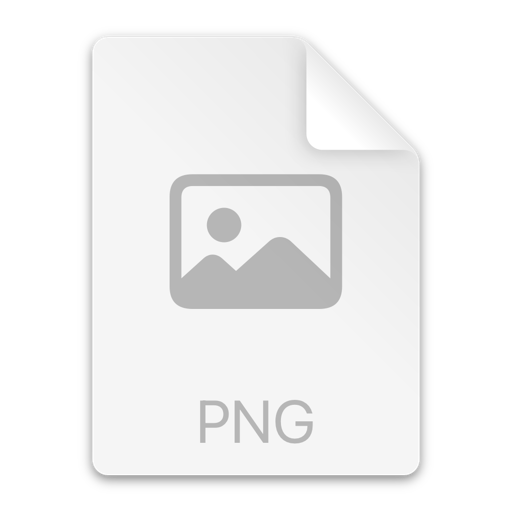

In [3]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 掩蔽softmax操作

正如上面提到的，softmax操作用于输出一个概率分布作为注意力权重。 在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。 例如，为了在 9.5节中高效处理小批量数据集， 某些文本序列被填充了没有意义的特殊词元。 为了仅将有意义的词元作为值来获取注意力汇聚， 可以指定一个有效序列长度（即词元的个数）， 以便在计算softmax时过滤掉超出指定范围的位置。 下面的masked_softmax函数 实现了这样的掩蔽softmax操作（masked softmax operation）， 其中任何超出有效长度的位置都被掩蔽并置为0。


In [4]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        print(f"\nmask:\n{mask}")
        X[~mask] = value
        print(f"\nafter mask, X:\n{X}")
        return X
    # X:3D张量，形状为(batch_size, seq_len, features)
    # valid_lens:1D或2D张量，有效长度张量，指定每个序列的有效长度
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape # 保存原始输入张量的形状。
        print(f"\nshape:\n {shape}")
        if valid_lens.dim() == 1: # 1D张量
            print(f"\nbefore interleave:\n{valid_lens}")
            print(f"The number of repetitions for each element: {shape[1]}")
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
            print(f"\nafter interleave:\n{valid_lens}")
        else: # 2D张量
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        Z = X.reshape(-1, shape[-1])
        print(f"\nZ:\n{Z}")
        X = _sequence_mask(Z, valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

张量维度的语义含义
* 在注意力计算中，输入张量 X 的形状通常为 (batch_size, seq_len, features)
* 其中 seq_len（序列长度）维度包含了针对不同位置的注意力分数
* 最后一个维度（features）在经过评分函数计算后，实际上存储的是各个位置的注意力原始分数
* 因此在最后一个维度上执行 softmax，就是对序列中每个位置的注意力分数进行归一化

为了演示此函数是如何工作的，考虑由两个 $2 \times 4$ 矩阵表示的样本，这两个样本的有效长度分别为 $2$ 和 $3$。经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0。


In [5]:
X = torch.rand(2, 2, 4)
Y = torch.tensor([2, 3])
print(f"X:\n {X}")
print(f"\nY:\n {Y}")
masked_softmax(X, Y)

X:
 tensor([[[0.6917, 0.4075, 0.3632, 0.9626],
         [0.2503, 0.3876, 0.8158, 0.9394]],

        [[0.2116, 0.6418, 0.1203, 0.9084],
         [0.8597, 0.0532, 0.2282, 0.9836]]])

Y:
 tensor([2, 3])

shape:
 torch.Size([2, 2, 4])

before interleave:
tensor([2, 3])
The number of repetitions for each element: 2

after interleave:
tensor([2, 2, 3, 3])

Z:
tensor([[0.6917, 0.4075, 0.3632, 0.9626],
        [0.2503, 0.3876, 0.8158, 0.9394],
        [0.2116, 0.6418, 0.1203, 0.9084],
        [0.8597, 0.0532, 0.2282, 0.9836]])

mask:
tensor([[ True,  True, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True, False]])

after mask, X:
tensor([[ 6.9172e-01,  4.0752e-01, -1.0000e+06, -1.0000e+06],
        [ 2.5025e-01,  3.8762e-01, -1.0000e+06, -1.0000e+06],
        [ 2.1156e-01,  6.4178e-01,  1.2030e-01, -1.0000e+06],
        [ 8.5967e-01,  5.3176e-02,  2.2825e-01, -1.0000e+06]])


tensor([[[0.5706, 0.4294, 0.0000, 0.0000],
         [0.4657, 0.5343, 0.0000, 0.0000]],

        [[0.2898, 0.4456, 0.2645, 0.0000],
         [0.5055, 0.2257, 0.2688, 0.0000]]])

If we need more fine-grained control to specify the valid length for each of the two vectors of every example, we simply use a two-dimensional tensor of valid lengths. This yields:

In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))


shape:
 torch.Size([2, 2, 4])

Z:
tensor([[4.5610e-01, 9.1892e-01, 7.4355e-01, 4.1819e-01],
        [1.5512e-01, 6.9527e-01, 5.1943e-01, 2.7663e-01],
        [1.6109e-01, 8.3886e-01, 1.3394e-02, 7.6976e-01],
        [8.6259e-01, 8.0848e-01, 1.4925e-04, 8.9790e-01]])

mask:
tensor([[ True, False, False, False],
        [ True,  True,  True, False],
        [ True,  True, False, False],
        [ True,  True,  True,  True]])

after mask, X:
tensor([[ 4.5610e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06],
        [ 1.5512e-01,  6.9527e-01,  5.1943e-01, -1.0000e+06],
        [ 1.6109e-01,  8.3886e-01, -1.0000e+06, -1.0000e+06],
        [ 8.6259e-01,  8.0848e-01,  1.4925e-04,  8.9790e-01]])


tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2406, 0.4130, 0.3464, 0.0000]],

        [[0.3368, 0.6632, 0.0000, 0.0000],
         [0.2937, 0.2782, 0.1240, 0.3042]]])

## Batch Matrix Multiplication

Another commonly used operation is to multiply batches of matrices by one another. This comes in handy when we have minibatches of queries, keys, and values. More specifically, assume that:

另一种常用的运算操作是将一批矩阵相互相乘。当我们将查询、键和值都划分为小批量时，这种操作就很有用。更具体地说，假设:

![image.png](../images/batch_matrix_multi_1.png)

Then the batch matrix multiplication (BMM) computes the elementwise product

然后，批量矩阵乘法（BMM）计算元素级乘积

![image.png](../images/batch_matrix_multi_2.png)
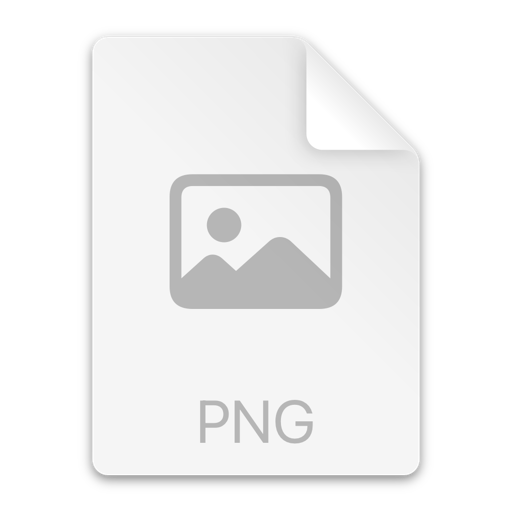
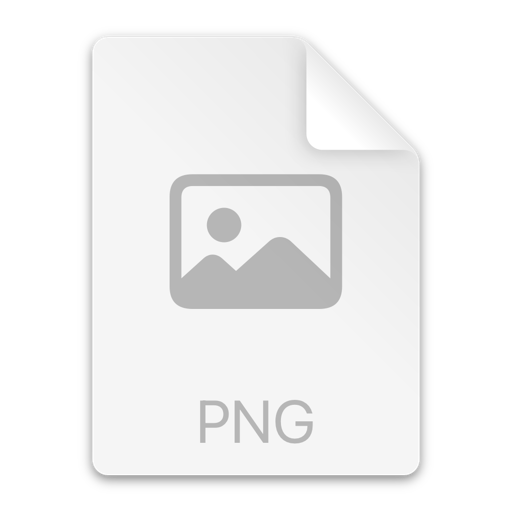

In [6]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

## 缩放点积注意力 Scaled Dot Product Attention

使用点积可以得到计算效率更高的评分函数，但是点积操作要求查询和键具有相同的长度 $d$。
假设查询和键的所有元素都是独立的随机变量，并且都满足零均值和单位方差，那么两个向量的点积的均值为 $0$ ，方差为 $d$。
为确保无论向量长度如何，点积的方差在不考虑向量长度的情况下仍然是 $1$ ，我们再将点积除以 $\sqrt{d}$ ，则 *缩放点积注意力*（scaled dot-product attention）评分函数为：

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}.$$

在实践中，我们通常从小批量的角度来考虑提高效率，例如基于 $n$ 个查询和 $m$ 个键－值对计算注意力，其中查询和键的长度为 $d$，值的长度为 $v$。
查询 $\mathbf Q\in\mathbb R^{n\times d}$、键 $\mathbf K\in\mathbb R^{m\times d}$ 和值 $\mathbf V\in\mathbb R^{m\times v}$ 的缩放点积注意力是：

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`

下面的缩放点积注意力的实现使用了暂退法进行模型正则化。


In [6]:
#@save
class DotProductAttention(nn.Module): # 继承自nn.Module，使其成为一个PyTorch神经网络模块
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        # 初始化一个dropout层，用于防止过拟合
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        print(f"\nd:{d}")
        # 交换keys的最后两个维度
        # 除以math.sqrt(d)进行缩放，这是论文中的关键创新，防止点积值过大导致softmax梯度消失
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        # 掩蔽无效位置，确保这些位置不会对注意力权重产生影响
        self.attention_weights = masked_softmax(scores, valid_lens)
        print(f"\nshape of attention weights:\n{self.attention_weights.shape}")
        print(f"\nattention weights:\n{self.attention_weights}")
        print(f"\nshape of values:\n{values.shape}")
        print(f"\nvalues:\n{values}")
        return torch.bmm(self.dropout(self.attention_weights), values)

为了[**演示上述的`DotProductAttention`类**]，
我们使用与先前加性注意力例子中相同的键、值和有效长度。
对于点积操作，我们令查询的特征维度与键的特征维度大小相同。


In [62]:
queries = torch.normal(mean=0, std=1, size=(2, 1, 2))
keys = torch.ones(size=(2, 10, 2)) # keys 一致
# keys = torch.normal(mean=0, std=1, size=(2, 10, 2))
# values的小批量数据集中，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
#values = torch.ones(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
print(f"\nqueries.shape:\n{queries.shape}")
print(f"\nqueries:\n {queries}")
print(f"\nkeys.shape:\n{keys.shape}")
print(f"\nkeys:\n {keys}")
print(f"\nvalues.shape:\n{values.shape}")
print(f"\nvalues:\n {values}")


queries.shape:
torch.Size([2, 1, 2])

queries:
 tensor([[[-0.3617,  0.8497]],

        [[ 0.1231, -0.4316]]])

keys.shape:
torch.Size([2, 10, 2])

keys:
 tensor([[[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]])

values.shape:
torch.Size([2, 10, 4])

values:
 tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20., 21., 22., 23.],
         [24., 25., 26., 27.],
         [28., 29., 30., 31.],
         [32., 33., 34., 35.],
         [36., 37., 38., 39.]],

        [[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
        

In [63]:
attention = DotProductAttention(dropout=0.5)
attention.eval()
result = attention(queries, keys, values, valid_lens)
print(f"\nresult.shape:\n{result.shape}")
print(f"\nresult:\n {result}")


d:2

shape:
 torch.Size([2, 1, 10])

before interleave:
tensor([2, 6])
The number of repetitions for each element: 1

after interleave:
tensor([2, 6])

Z:
tensor([[ 0.3450,  0.3450,  0.3450,  0.3450,  0.3450,  0.3450,  0.3450,  0.3450,
          0.3450,  0.3450],
        [-0.2181, -0.2181, -0.2181, -0.2181, -0.2181, -0.2181, -0.2181, -0.2181,
         -0.2181, -0.2181]])

mask:
tensor([[ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False]])

after mask, X:
tensor([[ 3.4505e-01,  3.4505e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06,
         -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06],
        [-2.1812e-01, -2.1812e-01, -2.1812e-01, -2.1812e-01, -2.1812e-01,
         -2.1812e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06]])

shape of attention weights:
torch.Size([2, 1, 10])

attention weights:
tensor([[[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.00

forward 方法调用

```
module_instance(input)  # 用户调用
   ↓
   __call__()  # nn.Module.__call__
   ↓
   _wrapped_call_impl
   ↓
   _call_impl() -> inner() -> forward_call()
   ↓
   self.forward()  # 具体实现子类的forward方法
```

与加性注意力演示相同，由于键包含的是相同的元素，
而这些元素无法通过任何查询进行区分，因此获得了[**均匀的注意力权重**]。


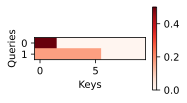

In [57]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')


d:2

shape:
 torch.Size([2, 1, 10])

before interleave:
tensor([2, 6])
The number of repetitions for each element: 1

after interleave:
tensor([2, 6])

Z:
tensor([[ 2.2072,  1.7063, -1.0833,  3.1358,  0.1657, -2.2702, -1.1404, -0.8720,
         -0.3355,  1.5372],
        [-0.1138, -0.1196,  0.0251, -0.0442, -0.1292,  0.0690,  0.0172,  0.0823,
          0.1755, -0.2187]])

mask:
tensor([[ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False]])

after mask, X:
tensor([[ 2.2072e+00,  1.7063e+00, -1.0000e+06, -1.0000e+06, -1.0000e+06,
         -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06],
        [-1.1382e-01, -1.1963e-01,  2.5107e-02, -4.4164e-02, -1.2916e-01,
          6.9010e-02, -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06]])

shape of attention weights:
torch.Size([2, 1, 10])

attention weights:
tensor([[[0.6227, 0.3773, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.00

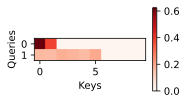

In [61]:
keys = torch.normal(mean=0, std=1, size=(2, 10, 2))
values = torch.ones(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
attention = DotProductAttention(dropout=0.5)
attention.eval()
result = attention(queries, keys, values, valid_lens)
print(f"\nresult.shape:\n{result.shape}")
print(f"\nresult:\n {result}")
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## 小结

* 将注意力汇聚的输出计算可以作为值的加权平均，选择不同的注意力评分函数会带来不同的注意力汇聚操作。
* 当查询和键是不同长度的矢量时，可以使用可加性注意力评分函数。当它们的长度相同时，使用缩放的“点－积”注意力评分函数的计算效率更高。
